# Example 12: Unsupervised learning

In this example, we will use KAN for unsupervised learning. Instead of trying to figure out how a target variable $y$ depends on input variables, we treat all variables on the equal footing (as input variables). Below we contruct a synthetic dataset where we have six variables $x_1, x_2, x_3, x_4, x_5, x_6$. $(x_1, x_2, x_3)$ are dependent such that $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$; $(x_4,x_5)$ are dependent such that $x_5=x_4^3$. And $x_6$ is independent of all other variables. Can we use KANs to discover these dependent groups?

The idea is that we treat the problem as a classification problem. The dataset that satisfies these interdependent relations are 'positive' samples, while corrupted samples (by random permutation of features across samples) are 'negative' samples. We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer. We can then define the relation implicitly as $g=0$ where $g$ is the activation in the second to last layer.

Intialize model and create dataset

In [227]:
from kan import KAN
import torch
import copy

seed = 1
model = KAN(width=[6,1,1], grid=3, k=3, seed=seed)

# create dataset


def create_dataset(train_num=500, test_num=500):
    
    def generate_contrastive(x):
        # positive samples
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # negative samples
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y
        
    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)
    
    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)
    
    dataset = {}
    dataset['train_input'] = x_train
    dataset['test_input'] = x_test
    dataset['train_label'] = y_train
    dataset['test_label'] = y_test
    return dataset

dataset = create_dataset()

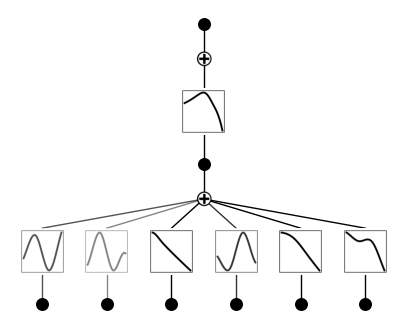

In [228]:
model(dataset['train_input'])
model.plot(beta=10)

In [229]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

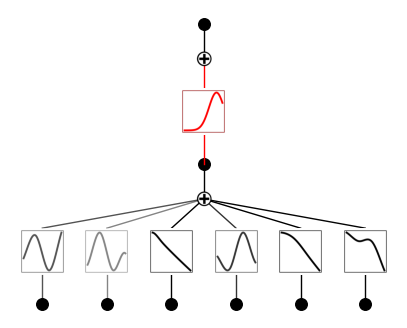

In [230]:
model(dataset['train_input'])
model.plot(beta=10)

In [243]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0);

train loss: 1.85e-01 | test loss: 1.81e-01 | reg: 2.80e+01 : 100%|██| 50/50 [00:01<00:00, 28.06it/s]


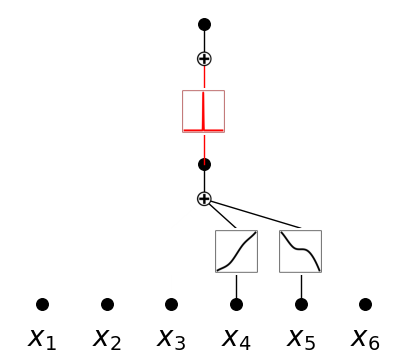

In [244]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [246]:
model.feature_score

tensor([6.4240e-08, 2.1133e-07, 1.2317e-03, 9.4749e-01, 9.4972e-01, 6.8621e-08])

This gives the dependence among $(x_4,x_5)$. Another random seed can give dependence among $(x_1,x_2,x_3)$.

In [271]:
seed = 6
model = KAN(width=[6,1,1], grid=3, k=3, seed=seed)
dataset = create_dataset()

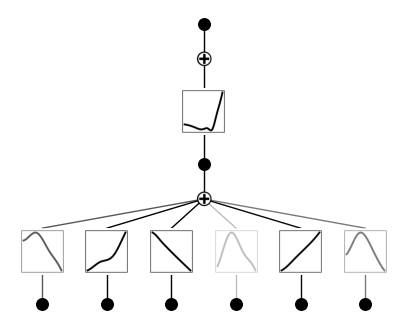

In [272]:
model(dataset['train_input'])
model.plot(beta=10)

In [273]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

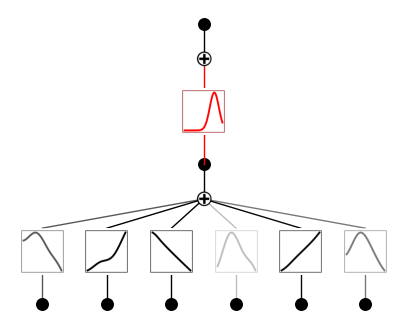

In [274]:
model(dataset['train_input'])
model.plot(beta=10)

In [275]:
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);

train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.05e+00 : 100%|█| 100/100 [00:05<00:00, 19.63it/s


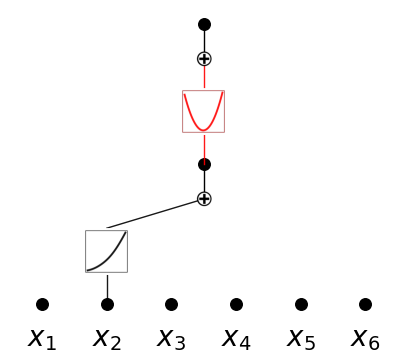

In [276]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [256]:
torch.max(model.feature_score).item()

1.0317829847335815

In [278]:
dataset = create_dataset()

scores = []
for seed in range (10):
    model = KAN(width=[6, 1, 1], grid=3, k=3, seed=seed)
    model(dataset['train_input'])
    model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)
    model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);
    sorted = torch.sort(model.feature_score)
    score = torch.mean(sorted.values[-2:]).item()
    positions = (torch.sort(sorted.indices[-2:]).values).numpy()
    scores.append((score, positions))
    print(seed, scores[-1])

train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.46e-01 : 100%|█| 100/100 [00:04<00:00, 24.32it/s


0 (0.14154678583145142, array([1, 4]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.19e-02 : 100%|█| 100/100 [00:05<00:00, 18.29it/s


1 (0.00033990349038504064, array([3, 5]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.08e+00 : 100%|█| 100/100 [00:05<00:00, 18.67it/s


2 (0.000315856043016538, array([3, 4]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 2.19e+00 : 100%|█| 100/100 [00:04<00:00, 23.36it/s


3 (0.5723770260810852, array([3, 5]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.02e-01 : 100%|█| 100/100 [00:05<00:00, 17.20it/s


4 (0.02635996788740158, array([0, 3]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 2.22e-01 : 100%|█| 100/100 [00:04<00:00, 22.09it/s


5 (0.048839014023542404, array([0, 5]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.61e+00 : 100%|█| 100/100 [00:04<00:00, 20.59it/s


6 (0.0, array([4, 5]))


train loss: 1.87e-01 | test loss: 1.85e-01 | reg: 7.02e+00 : 100%|█| 100/100 [00:08<00:00, 12.17it/s


7 (1.0211275815963745, array([3, 4]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.24e-01 : 100%|█| 100/100 [00:04<00:00, 20.31it/s


8 (0.015930164605379105, array([1, 5]))


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.26e+00 : 100%|█| 100/100 [00:04<00:00, 21.93it/s


9 (0.4266201853752136, array([0, 1]))


In [264]:
scores

[0.2830895185470581,
 0.0006622958462685347,
 0.0006317063816823065,
 0.8377614617347717,
 0.05270165205001831,
 0.09767170995473862,
 0.0,
 1.021706223487854,
 0.03185877203941345,
 0.8532400131225586]

In [222]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

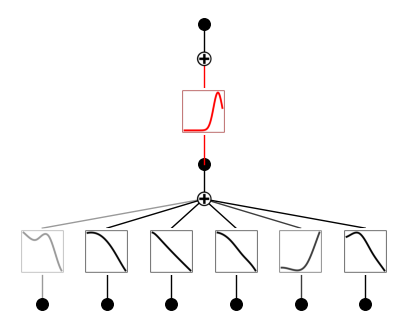

In [223]:
model(dataset['train_input'])
model.plot(beta=10)

In [224]:
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.01, lamb_coef=1.0);


train loss: 5.00e-01 | test loss: 5.00e-01 | reg: 1.21e+00 : 100%|█| 100/100 [00:06<00:00, 15.54it/s
